In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import pandas as pd
!cp '/content/drive/MyDrive/ML projet/create_dataset.py' './'
!cp '/content/drive/MyDrive/ML projet/load_data.py' './'
import create_dataset
from create_dataset import * 
import load_data
from load_data import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

In [ ]:
np.random.seed(42)

In [ ]:
ml_folder = Path('/content/drive/MyDrive/ML projet')
ml_folder.exists()
data_path = ml_folder/'DataLFP.mat'

In [ ]:
X_wS1, y_wS1 = preprocess_dataset(data_path, 'wS1', start=2.5, select_amplitude=[2,3])
X_wS1.shape, y_wS1.shape

((1808, 4996), (1808,))

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

def bin(X, bin_size):
  nb_splits = X.shape[1]//bin_size
  splits = np.array_split(X,nb_splits,axis=1)
  splits = list(map(lambda x: x.mean(axis=1), splits))

  return np.stack(splits, axis=1)

def bin_agg(X, agg_funs, bin_size):
  nb_splits = X.shape[1]//bin_size
  splits = np.array_split(X,nb_splits,axis=1)
  splits = [agg_fun(x) for x in splits for agg_fun in agg_funs]

  return np.stack(splits, axis=1)

agg_funs = [lambda x: np.mean(x,axis=1), lambda x: np.std(x,axis=1), lambda x: np.min(x,axis=1), lambda x: np.max(x,axis=1)]


def eval_model(model, X, y, cv=10):
  return cross_val_score(model, X, y, cv=cv, scoring='accuracy')

def add_test_to_results(results, area, bin_size, accs):
  for acc in accs:
    results = results.append({'area' : area, 'bin size' : bin_size, 'accuracy' : acc},ignore_index=True)
  return results

class random_estimator():

  def __init__(self, param=None):
    pass
  
  def get_params(self, deep):
    return {}

  def fit(self, X,y):
    return self
  
  def predict(self, X):
    return np.random.randint(2, size=(X.shape[0]))

random_model = random_estimator()


In [ ]:
from sklearn.svm import SVC

In [ ]:
accs = []
model = SVC(gamma='auto', C=0.8)
bins_size = [1,2,10, 20, 50, 100, 500, 1000, 2000]

for bin_size in bins_size:
  print(f'{bin_size}')
  X_binned = bin(X_wS1, bin_size)
  accs.append(eval_model(model, X_binned, y_wS1))

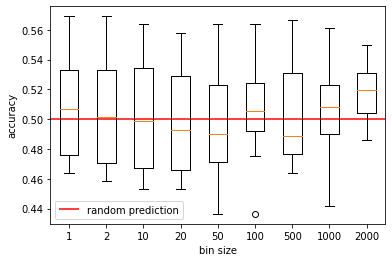

In [ ]:
plt.boxplot(accs)
plt.xticks(range(10),labels=['']+[f'{bins_size[i]}' for i in range(9)])
plt.hlines(0.5, 0.5, 9.5, colors='red', label='random prediction')
plt.xlabel('bin size')
plt.ylabel('accuracy')

plt.legend()
plt.show()

In [ ]:
accs = []
model = SVC(gamma='auto', C=0.8)
bins_size = [4,10, 20, 50, 100, 500, 1000, 2000]

for bin_size in bins_size:
  print(f'{bin_size}')
  X_binned = bin_agg(X_wS1, agg_funs, bin_size)
  accs.append(eval_model(model, X_binned, y_wS1))

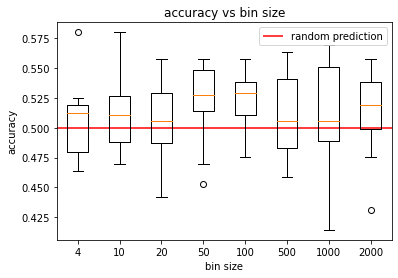

In [ ]:
plt.boxplot(accs)
plt.xticks(range(9),labels=['']+[f'{bins_size[i]}' for i in range(8)])
plt.hlines(0.5, 0.5, 8.5, colors='red', label='random prediction')
plt.title('accuracy vs bin size')
plt.xlabel('bin size')
plt.ylabel('accuracy')

plt.legend()
plt.show()

In [ ]:
X_mPFC, y_mPFC = preprocess_dataset(data_path, 'mPFC', start=2.5, select_amplitude=[2,3])
X_mPFC.shape, y_mPFC.shape

((1292, 4996), (1292,))

In [ ]:
X_tjM1, y_tjM1 = preprocess_dataset(data_path, 'tjM1', start=2.5, select_amplitude=[2,3])
X_tjM1.shape, y_tjM1.shape

((582, 4996), (582,))

In [ ]:
accs = []
model = SVC(gamma='auto', C=0.8)
bins_size = [4,10, 20, 50, 100, 500, 1000, 2000]

for bin_size in bins_size:
  print(f'{bin_size}')
  X_binned = bin_agg(X_tjM1, agg_funs, bin_size)
  accs.append(eval_model(model, X_binned, y_tjM1))

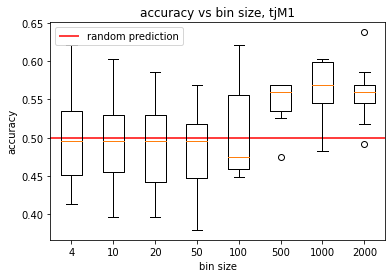

In [ ]:
plt.boxplot(accs)
plt.xticks(range(9),labels=['']+[f'{bins_size[i]}' for i in range(8)])
plt.hlines(0.5, 0.5, 8.5, colors='red', label='random prediction')
plt.title('accuracy vs bin size, tjM1')
plt.xlabel('bin size')
plt.ylabel('accuracy')

plt.legend()
plt.show()

In [ ]:
accs = []
model = SVC(gamma='auto', C=0.8)
bins_size = [4,10, 20, 50, 100, 500, 1000, 2000]

for bin_size in bins_size:
  print(f'{bin_size}')
  X_binned = bin_agg(X_mPFC, agg_funs, bin_size)
  accs.append(eval_model(model, X_binned, y_mPFC))

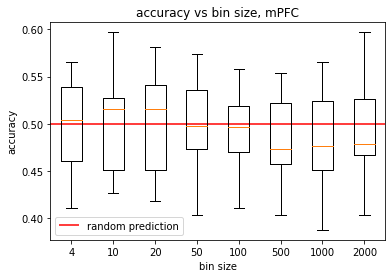

In [ ]:
plt.boxplot(accs)
plt.xticks(range(9),labels=['']+[f'{bins_size[i]}' for i in range(8)])
plt.hlines(0.5, 0.5, 8.5, colors='red', label='random prediction')
plt.title('accuracy vs bin size, mPFC')
plt.xlabel('bin size')
plt.ylabel('accuracy')

plt.legend()
plt.show()

In [ ]:
X, y = X_wS1, y_wS1
X_binned = bin_agg(X, agg_funs, 50)
accs = []

for c in np.logspace(-1,1,num=20):
  accs.append([])
  for bin_size in [50, 250, 500]:
    X_binned = bin_agg(X, agg_funs, bin_size)
    model = SVC(gamma='auto', C=c)
    accs[-1].append(eval_model(model, X_binned, y, cv=5).mean())

In [ ]:
for i in range(len(accs)):
  print(f'c={np.logspace(-1,1,num=20)[i]} : {accs[i]}')

c=0.1 : [0.5104758115119145, 0.5143600495860181, 0.5159914907944476]
c=0.12742749857031338 : [0.5071517117889227, 0.5171194196599379, 0.5209745795136285]
c=0.16237767391887217 : [0.5060528611438453, 0.5187799390887804, 0.5187646347622473]
c=0.20691380811147897 : [0.5049478887681548, 0.5209822316768952, 0.5143401539615249]
c=0.26366508987303583 : [0.5099202644587625, 0.5187799390887804, 0.5148987618799834]
c=0.33598182862837817 : [0.5154558393657888, 0.5182289833335884, 0.512687286695949]
c=0.42813323987193935 : [0.5182335746315483, 0.5160159777169006, 0.5077118501400346]
c=0.5455594781168519 : [0.5210097794646547, 0.5143615800186713, 0.5077133805726879]
c=0.6951927961775606 : [0.5259821551552625, 0.5143615800186713, 0.51490641404325]
c=0.8858667904100825 : [0.5232166633507292, 0.5187937129826602, 0.5198864418971243]
c=1.1288378916846888 : [0.5204603541421159, 0.5265422935063743, 0.5143493365574449]
c=1.438449888287663 : [0.5199032766563108, 0.523785984297761, 0.5132428337491008]
c=1.83

In [ ]:
bins_size = [50,100, 250, 500, 750]
areas = ['wS1', 'tjM1', 'mPFC']
datas = [(X_wS1,y_wS1), (X_tjM1, y_tjM1), (X_mPFC,y_mPFC)]
results = pd.DataFrame(columns=['area', 'bin size', 'accuracy']) 
model = SVC(gamma='auto', C=0.8)

for area, data in list(zip(areas, datas)):
  X,y = data
  for bin_size in bins_size:

    print(f'{bin_size}')
    X_binned = bin_agg(X, agg_funs, bin_size)
    results = add_test_to_results(results, area,bin_size,eval_model(model, X_binned, y))

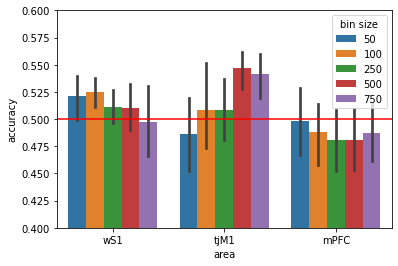

In [ ]:
sn.barplot(x="area", y="accuracy", ci=95, hue="bin size", data=results)
plt.ylim([0.4,0.6])
plt.axhline(y=0.5, color='r', linestyle='-')

In [ ]:
results.groupby(['area','bin size'], axis=0).apply(lambda x:x.accuracy.mean()).reset_index()

,area,bin size,0
0,mPFC,50,0.498420
1,mPFC,100,0.488372
2,mPFC,250,0.480626
3,mPFC,500,0.480561
4,mPFC,750,0.487591
5,tjM1,50,0.486324
6,tjM1,100,0.508767
7,tjM1,250,0.508591
8,tjM1,500,0.546552
9,tjM1,750,0.541321
